In [1]:
import findspark
findspark.init()
findspark.find()

'/opt/conda/lib/python3.10/site-packages/pyspark'

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Global Terror").getOrCreate()

23/06/09 21:48:22 WARN Utils: Your hostname, codespaces-282530 resolves to a loopback address: 127.0.0.1; using 172.16.5.4 instead (on interface eth0)
23/06/09 21:48:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/06/09 21:48:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
csv_path = '/workspaces/codespaces-jupyter/sektorel/terorizim/data/globalterrorismdb_0718dist.csv'

data_terrors = spark.read \
    .options(header = "true", inferSchema = "true") \
    .csv(csv_path)

In [5]:
from pyspark.sql.functions import col

# terrors = data_terrors.fillna("None")

# aşağıdaki satırı çeviri yaparken TypeError alacağımız yerlere yapıştırabiliriz.
# df = df_terrors.filter(col("column_name") != "N/A")

# Uyarı! : Bazen kullanılan Translate Apiden kaynaklı hatalar yaşanabiliyor bunu çözmek için hücreyi bir kaç defa daha çalıştırmalıyız.  
terrors = data_terrors.filter(col("iyear") <= 2013)

In [5]:
from pyspark.sql.functions import desc

terror_orderBy_years = terrors.orderBy(desc("iyear"))

In [6]:
terror_orderBy_years.show(10, truncate = False)

23/06/03 10:06:32 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------+-----+------+----+----------+--------+----------+-------+-----------+------+--------------------------+------------------+------------+---------+---------+-----------+--------+----------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+-----+-----+---------+-----------+----------------+--------+-------+-------+-----------+-----------------+-----------+---------------+-----------+---------------+---------+----------------------------+------------+-------------------------------------------------+------------------------------+--------------------------------------------

Soru 1 - Dünyada en çok terör vakası tam olarak hangi adreste gerçekleşmiştir?

In [214]:
from googletrans import Translator
from pyspark.sql.functions import desc

from geopy.geocoders import Nominatim


import folium

line = "==========================================================================="

filtered_data = terrors.select("latitude", "longitude")

most_terror_location = filtered_data.groupBy("latitude", "longitude").count().orderBy(desc("count")).first()

print("En fazla terör olayı gerçekleşen konum:")
print("Latitude: ", most_terror_location["latitude"])
print("Longitude: ", most_terror_location["longitude"])
print(line)
latitude = most_terror_location["latitude"]
longitude = most_terror_location["longitude"]

###############################################################################

def find_location(latitude, longitude):
    geolocator = Nominatim(user_agent="location_app")
    location = geolocator.reverse((latitude, longitude), exactly_one=True)
    if location is not None:
        return location.address # type: ignore

result = find_location(latitude,longitude)
print("Konum: ", result)

###############################################################################

result = find_location(latitude, longitude)
if result:
    translator = Translator()
    translated_result = translator.translate(result, dest="tr").text
    print("(tr) Konum: ", translated_result)
else:
    print("Konum bulunamadı.")
print(line)


###############################################################################

map = folium.Map(location=[latitude, longitude], zoom_start=12)
folium.Marker([latitude, longitude], popup="Konum").add_to(map)
map

En fazla terör olayı gerçekleşen konum:
Latitude:  33.303566
Longitude:  44.371773
Konum:  213-23, محلة 213, حي الكندي, ناحية مرکز قضاء الکرخ, الكرخ, بغداد, بلدية الكرخ, محافظة بغداد, 10092, العراق
(tr) Konum:  213-23, Yerellik 213, Al-Kindi mahallesi, Al-Karkh Bölgesi, Karkh, Bağdat, El-Karkh Belediyesi, Bağdat Valiliği, 10092, Irak


Soru 2 - Dünyada terör vakalarının en sık yaşandığı, insanların uzak durması gereken 5 bölge neresidir? 

In [164]:
from pyspark.sql import SparkSession
from geopy.geocoders import Nominatim
import folium


# "latitude", "longitude" ve "city" sütunlarını seç ve null değerleri filtrele
filtered_data = terrors.select("latitude", "longitude", "city").filter(terrors.latitude.isNotNull() & terrors.longitude.isNotNull())

# En tehlikeli 5 yeri bul
most_dangerous_locations = filtered_data.groupBy("latitude", "longitude", "city").count().orderBy("count", ascending=False).limit(5).collect()

# Harita oluştur
world_map = folium.Map(location=[0, 0], zoom_start=2)

# GeoCoder oluştur
geolocator = Nominatim(user_agent="my_geocoder")

# En tehlikeli yerleri haritada işaretle
for location in most_dangerous_locations:
    lat, lon, city = location["latitude"], location["longitude"], location["city"]
    
    # Koordinatları adres bilgisine dönüştür
    location_info = geolocator.reverse((lat, lon), exactly_one=True)
    address = location_info.address if location_info else "Address not found" # type: ignore
    
    # Adresi ve şehri birleştirerek işaretçi için popup metni oluştur
    popup_text = f"{address}, {city}"
    
    # İşaretçiyi haritaya ekle
    folium.Marker([lat, lon], popup=popup_text).add_to(world_map)

# Haritayı göster
world_map


Soru - Terör saldırılarının; başarılı ve başarısız, toplam ölü ve yaralı sayılarını, başarı oranını ve ortlama zarar veren kişi sayısını analiz sonuçları nedir? Grafiklerle gösteriniz.

Toplam saldırı sayısı: 125336
Başarılı saldırı sayısı: 114026
Başarısız saldırı sayısı: 11120
Toplam ölü sayısı: 265666.0
Toplam yaralı sayısı: 371529.0
Başarı oranı (%): 90.97625582434416
Ortalama zarar veren kişi sayısı: 5.083894491606562


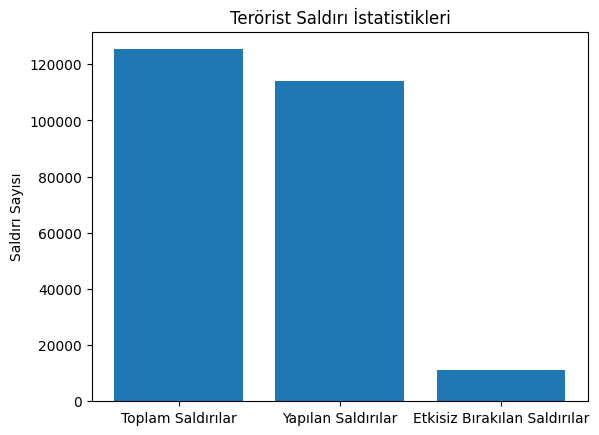

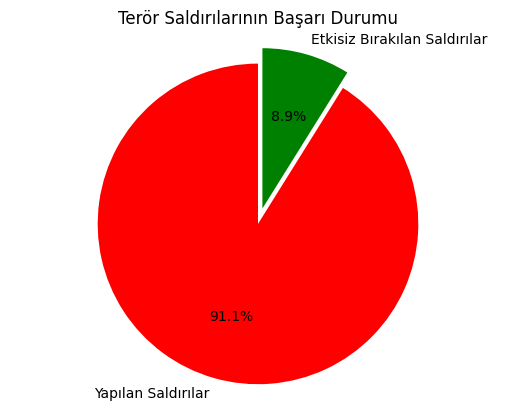

In [165]:
from pyspark.sql.functions import col, when
import matplotlib.pyplot as plt


def calculate_attack_impact():
    total_attacks = terrors.count()
    successful_attacks = terrors.filter(col("success") == 1).count()
    unsuccessful_attacks = terrors.filter(col("success") == 0).count()

    successful_attack_percentage = (successful_attacks / total_attacks) * 100
    unsuccessful_attack_percentage = (unsuccessful_attacks / total_attacks) * 100

    labels = ['Yapılan Saldırılar', 'Etkisiz Bırakılan Saldırılar']
    sizes = [successful_attack_percentage, unsuccessful_attack_percentage]
    colors = ['red', 'green']
    explode = (0.1, 0)  # İlk dilimdeki vurgulama
    
    # Pasta grafiği oluştur
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')  # Dairesel şekilde göster
    plt.title('Terör Saldırılarının Başarı Durumu')
    plt.show()

def plot_results(total_attacks, successful_attacks, failed_attacks):
    labels = ['Toplam Saldırılar', 'Yapılan Saldırılar', 'Etkisiz Bırakılan Saldırılar']
    values = [total_attacks, successful_attacks, failed_attacks]

    fig, ax = plt.subplots()
    ax.bar(labels, values)
    ax.set_ylabel('Saldırı Sayısı')
    ax.set_title('Terörist Saldırı İstatistikleri')

    plt.show()

# Terörist saldırıların etkisini hesapla
total_attacks = terrors.count()
successful_attacks = terrors.filter(col("success") == 1).count()
failed_attacks = terrors.filter(col("success") == 0).count()

total_casualties = terrors.select(when(col("nkill").isNull(), 0).otherwise(col("nkill")).alias("nkill"),
                                  when(col("nwound").isNull(), 0).otherwise(col("nwound")).alias("nwound")).\
                    agg({"nkill": "sum", "nwound": "sum"}).\
                    collect()[0]

total_killed = total_casualties["sum(nkill)"]
total_wounded = total_casualties["sum(nwound)"]

success_rate = (successful_attacks / total_attacks) * 100
average_casualties_per_attack = (total_killed + total_wounded) / total_attacks

# Sonuçları yazdır
print("Toplam saldırı sayısı:", total_attacks)
print("Başarılı saldırı sayısı:", successful_attacks)
print("Başarısız saldırı sayısı:", failed_attacks)
print("Toplam ölü sayısı:", total_killed)
print("Toplam yaralı sayısı:", total_wounded)
print("Başarı oranı (%):", success_rate)
print("Ortalama zarar veren kişi sayısı:", average_casualties_per_attack)

# Grafik sonuçları çizdir
plot_results(total_attacks, successful_attacks, failed_attacks)

# Başarılı ve başarısız saldırıların etkisini hesapla ve grafik olarak göster
calculate_attack_impact()


Soru - Girilen bir ülke ismine ait 1 veya daha fazla terör vakasının genel verilerini yazdıran analiz kodu nedir?  

In [207]:
from pyspark.sql.functions import col, rand
from translate import Translator

# country = input("Ülke adını girin: ")
country = 'Turkey'

# Ülke ile ilgili gerçekleşen terör olaylarını seçin ve summary'si none olmayanları filtreleyin
filtered_events = terrors.filter((terrors.country_txt == country) & (col("summary").isNotNull()))

# Event ID, Year, Summary ve Target sütunlarını seçin
selected_columns = ["country_txt","eventid", "iyear", "summary", "targtype1_txt"]

# Terör olaylarını rastgele sıralayın ve ilk 5 sonucu alın
random_events = filtered_events.orderBy(rand()).limit(10)

# Sonuçları ayrı ayrı yazdırın
for row in random_events.collect():
    country = row["country_txt"]
    eventid = row["eventid"]
    year = row["iyear"]
    summary = row["summary"]
    target = row["targtype1_txt"]
    try:
        translator = Translator(to_lang="tr")
        translated_summary = translator.translate(summary)
    except TypeError:
        continue
    print("Country: ", country)
    print("Event ID:", eventid)
    print("Year:", year)
    print("Summary:", translated_summary)
    print("Target:", target)
    print("-----------------------")


Country:  Turkey
Event ID: 199907140004
Year: 1999
Summary: 14.07.1999: Türkiye'nin İstanbul ili Esenler ilçesinde bir servis otobüsüne yangın bombası atıldı. Araç hasar görmesine rağmen saldırıda herhangi bir kayıp bildirilmedi. Otobüs, Servet Turizm Şirketi'ne aitti ve bu gün saldırıya uğrayan iki otobüsten biriydi. Hiçbir grup veya birey bu saldırı için kredi talep etmedi.
Target: Transportation
-----------------------
Country:  Turkey
Event ID: 201301190015
Year: 2013
Summary: 19.01.2013: Türkiye'nin Mardin ilinin Yayvantepe ilçesinde Şırnak ile Midyat arasında bulunan Kerkük - Ceyhan petrol boru hattında patlayıcı patlatıldı. Patlamada kimse yaralanmadı; Ancak, gaz akışının alternatif bir boru hattına yönlendirilmesi gerekiyordu. Bu, bir gün içinde boru hattına yapılan iki saldırıdan biriydi. Saldırının sorumluluÄ  unu Kürdistan İÅ  çi Partisi'nin (PKK) alt grubu olan Hizen Parastina Gel üstlendi.
Target: Utilities
-----------------------
Country:  Turkey
Event ID: 200709140003


Soru - Dünyadaki terör olaylarında ki hedeflerin pasta grafiği nedir?

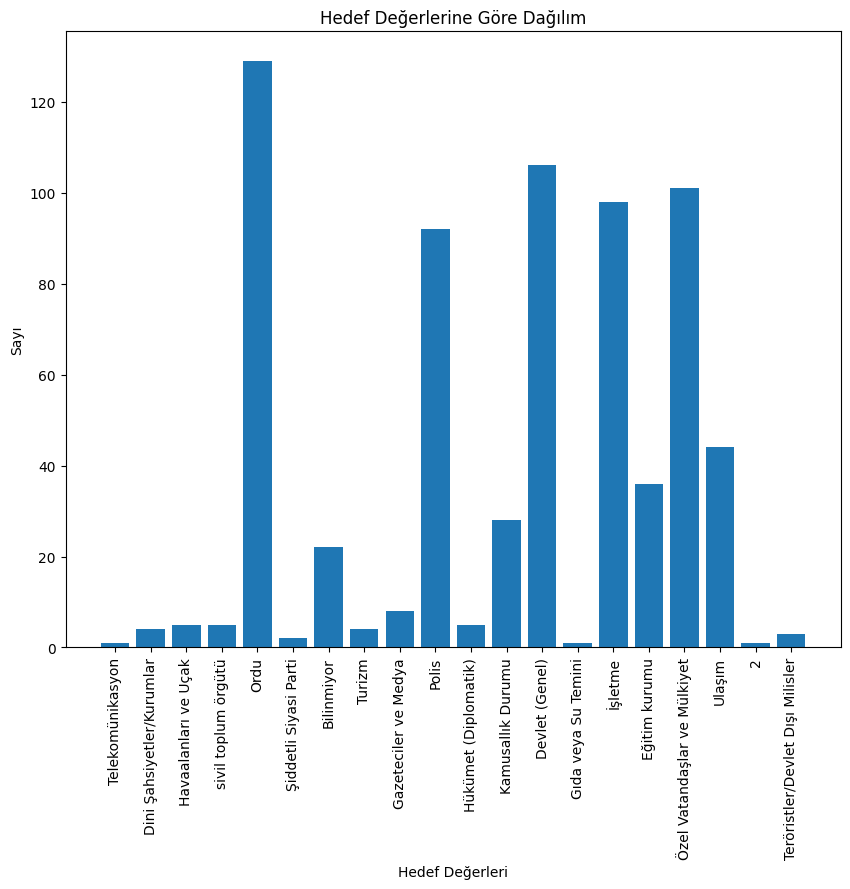

In [194]:
from translate import Translator
import matplotlib.pyplot as plt

# Ülke ile ilgili gerçekleşen terör olaylarını seçin ve summary'si none olmayanları filtreleyin
filtered_events = terrors.filter((terrors.country_txt == country) & (col("summary").isNotNull()))

# Target değerlerini gruplayın ve sayılarını hesaplayın
target_counts = filtered_events.groupby("targtype1_txt").count().collect()

# Target değerlerini Türkçe'ye çevirin
translator = Translator(to_lang="tr")
translated_targets = []
for row in target_counts:
    target_text = row["targtype1_txt"]
    if target_text is not None:
        translated_target = translator.translate(target_text)
        translated_targets.append(translated_target)

# Target değerleri ve sayılarını ayrı listelere ayırın
counts = [row["count"] for row in target_counts if row["targtype1_txt"] is not None]

# Çubuk grafik oluşturun
fig, ax = plt.subplots(figsize=(10, 8))
ax.bar(translated_targets, counts)
ax.set_xlabel("Hedef Değerleri")
ax.set_ylabel("Sayı")
ax.set_title("Hedef Değerlerine Göre Dağılım")

# Eksen etiketlerini döndür
plt.xticks(rotation=90)

# Grafiği göster
plt.show()


Soru - Dünyadaki terör olaylarının yıllara göre dağılımını veren grafik nedir?

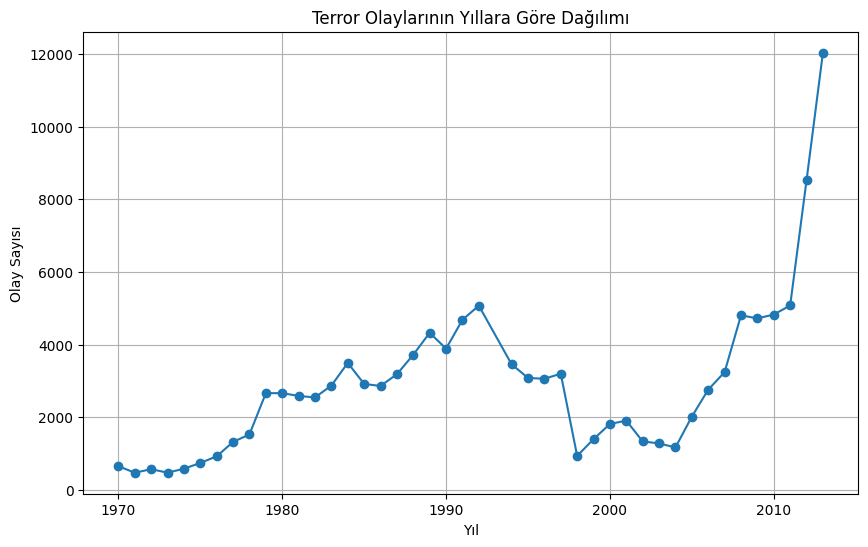

In [195]:
year_counts = terrors.groupby('iyear').count().orderBy('iyear').collect()

# Yıllar ve olay sayılarını ayrı listelere ayırın
years = [row['iyear'] for row in year_counts]
counts = [row['count'] for row in year_counts]

# Grafik oluşturun
plt.figure(figsize=(10, 6))
plt.plot(years, counts, marker='o')
plt.xlabel('Yıl')
plt.ylabel('Olay Sayısı')
plt.title('Terror Olaylarının Yıllara Göre Dağılımı')
plt.grid(True)

# Grafik göster
plt.show()


Soru - en fazla terör saldırısına maruz kalan ülkelerin (10) grafiği nasıldır?

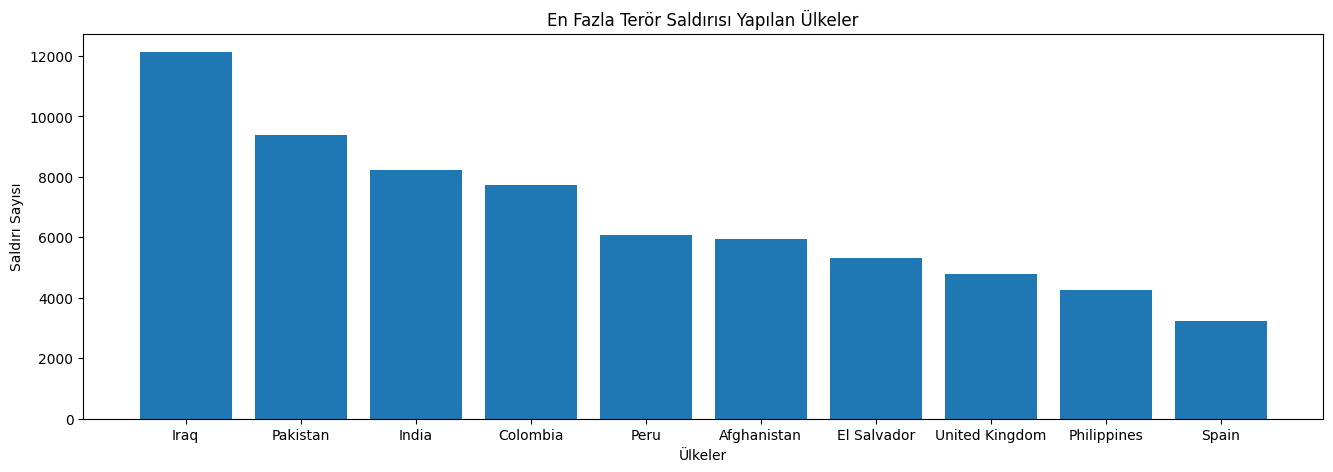

In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt



# Ülkelere göre terör saldırılarının sayısını hesaplayın
country_counts = terrors.groupby('country_txt').count().orderBy('count', ascending=False).limit(10).collect()

# Ülkeler ve saldırı sayılarını ayrı listelere ayırın
countries = [row['country_txt'] for row in country_counts]
attack_counts = [row['count'] for row in country_counts]

# Çubuk grafik oluşturun
plt.figure(figsize=(16, 5))
plt.bar(countries, attack_counts)
plt.xlabel('Ülkeler')
plt.ylabel('Saldırı Sayısı')
plt.title('En Fazla Terör Saldırısı Yapılan Ülkeler')

# Grafik göster
plt.show()


Soru - en az terör saldırısına maruz kalan ülkelerin (7) grafiği nasıldır?

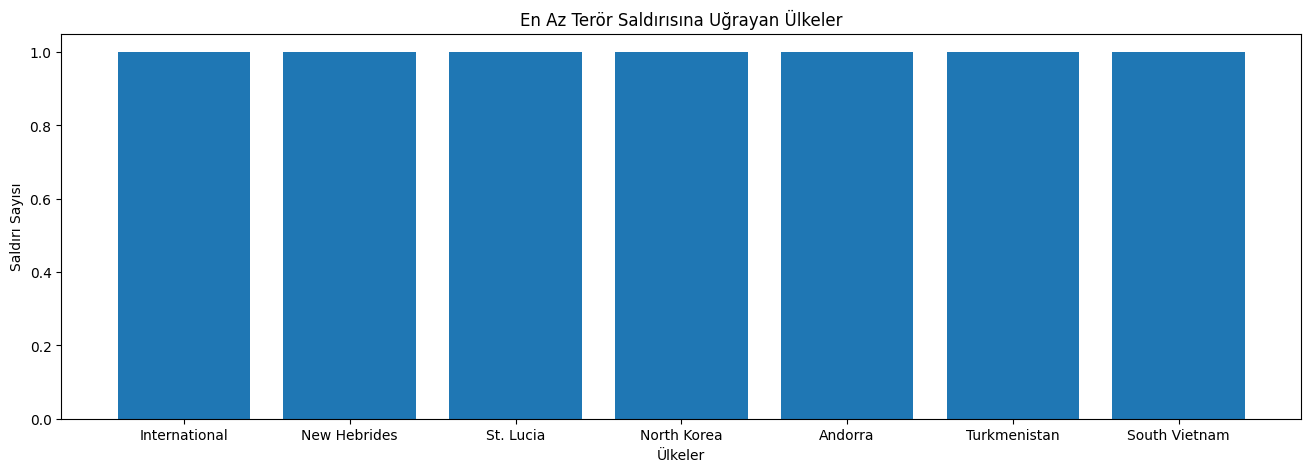

In [216]:
# Ülkelere göre terör saldırılarının sayısını hesaplayın
country_counts = terrors.groupby('country_txt').count().orderBy('count', ascending=True).limit(7).collect()

# Ülkeler ve saldırı sayılarını ayrı listelere ayırın
countries = [row['country_txt'] for row in country_counts]
attack_counts = [row['count'] for row in country_counts]

# Çubuk grafik oluşturun
plt.figure(figsize=(16, 5))
plt.bar(countries, attack_counts)
plt.xlabel('Ülkeler')
plt.ylabel('Saldırı Sayısı')
plt.title('En Az Terör Saldırısına Uğrayan Ülkeler')

# Grafik göster
plt.show()


Soru - Terör olaylarından en fazla korunan ve en başarılı savunmayı yapan ülkelerin grafiği nasıldır?

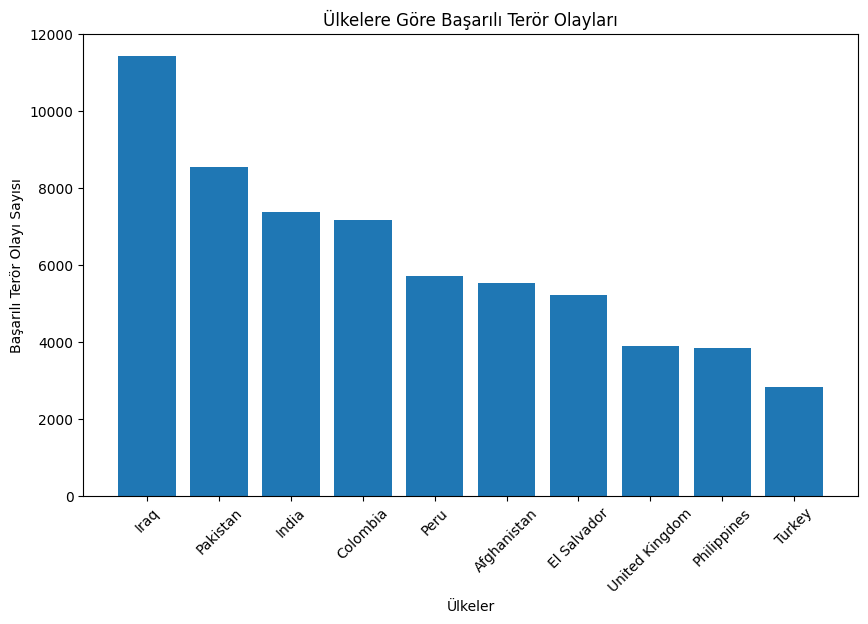

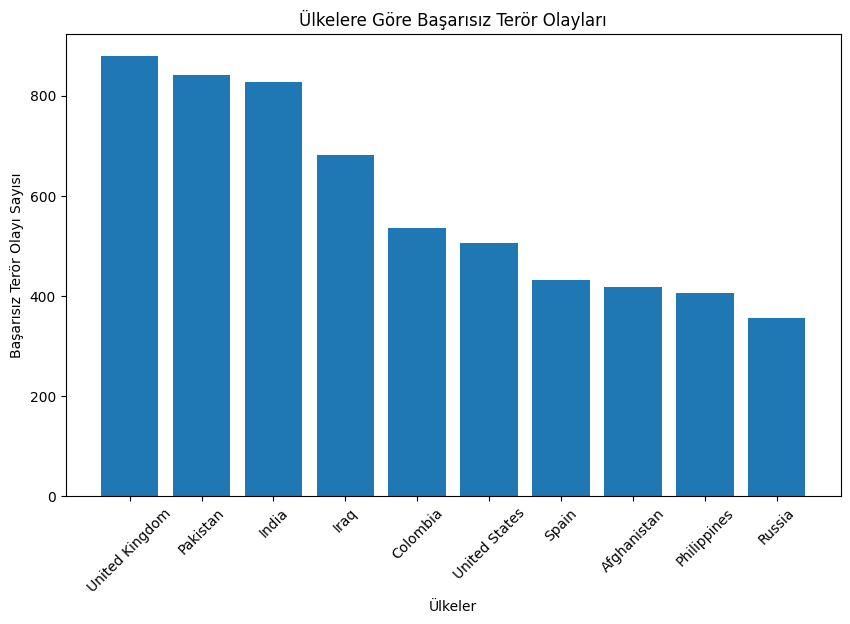

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col



# Başarılı ve başarısız terör olaylarını filtreleyin
successful_events = terrors.filter(col("success") == 1)
failed_events = terrors.filter(col("success") == 0)

# Ülkelerdeki başarılı terör olaylarını gruplayın ve sayılarını hesaplayın
successful_counts = successful_events.groupBy("country_txt").count().orderBy(col("count").desc()).limit(10).collect()

# Ülkelerdeki başarısız terör olaylarını gruplayın ve sayılarını hesaplayın
failed_counts = failed_events.groupBy("country_txt").count().orderBy(col("count").desc()).limit(10).collect()

# Başarılı terör olaylarının grafiği
successful_countries = [row["country_txt"] for row in successful_counts]
successful_values = [row["count"] for row in successful_counts]

plt.figure(figsize=(10, 6))
plt.bar(successful_countries, successful_values)
plt.xlabel("Ülkeler")
plt.ylabel("Başarılı Terör Olayı Sayısı")
plt.title("Ülkelere Göre Başarılı Terör Olayları")
plt.xticks(rotation=45)
plt.show()

# Başarısız terör olaylarının grafiği
failed_countries = [row["country_txt"] for row in failed_counts]
failed_values = [row["count"] for row in failed_counts]

plt.figure(figsize=(10, 6))
plt.bar(failed_countries, failed_values)
plt.xlabel("Ülkeler")
plt.ylabel("Başarısız Terör Olayı Sayısı")
plt.title("Ülkelere Göre Başarısız Terör Olayları")
plt.xticks(rotation=45)
plt.show()


Soru - Dünya üzerindeki bölgelerde yaşanan başarılı ve başarısız terör olaylarının grafiği nasıldır?

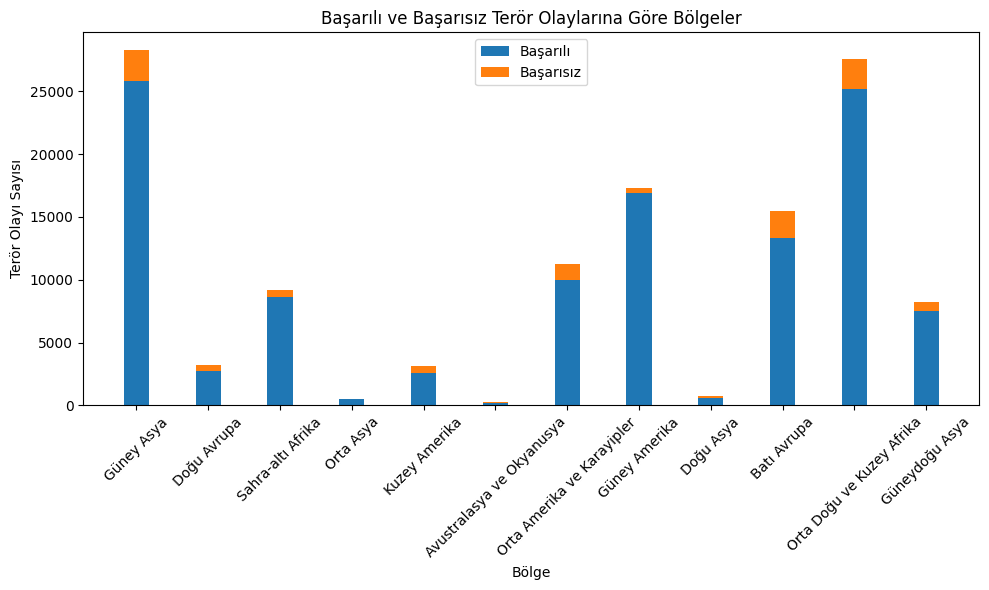

In [ ]:
from googletrans import Translator
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
# Başarılı ve başarısız terör olaylarını filtreleyin
successful_events = terrors.filter(col("success") == 1)
failed_events = terrors.filter(col("success") == 0)

# Başarılı terör olaylarının bölgelere göre sayısını hesaplayın
successful_counts = successful_events.groupBy("region_txt").count().collect()

# Başarısız terör olaylarının bölgelere göre sayısını hesaplayın
failed_counts = failed_events.groupBy("region_txt").count().collect()

# Bölgeleri ve ilgili sayıları ayrı listelere ayırın
regions = [row["region_txt"] for row in successful_counts]
successful_counts = [row["count"] for row in successful_counts]
failed_counts = [row["count"] for row in failed_counts]

# Bölge isimlerini Türkçe'ye çevirin
translator = Translator(service_urls=['translate.google.com'])
translated_regions = []
for region in regions:
    translated_region = translator.translate(region, dest="tr").text
    translated_regions.append(translated_region)

# Grafik oluşturun
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(translated_regions))

# Başarılı terör olayları için çubukları çizin
ax.bar(index, successful_counts, bar_width, label='Başarılı')

# Başarısız terör olayları için çubukları çizin
ax.bar(index, failed_counts, bar_width, label='Başarısız', bottom=successful_counts)

ax.set_xlabel("Bölge")
ax.set_ylabel("Terör Olayı Sayısı")
ax.set_title("Başarılı ve Başarısız Terör Olaylarına Göre Bölgeler")
ax.set_xticks(index)
ax.set_xticklabels(translated_regions, rotation=45)
ax.legend()

# Grafik göster
plt.tight_layout()
plt.show()


Soru - En fazla başarısızlığa uğramış ilk 5 terör saldırısı kimler tarafından gerçekleştirilmiştir ve bu saldırılarda hedefler kimler olmuştur? Grafiğini veriniz.

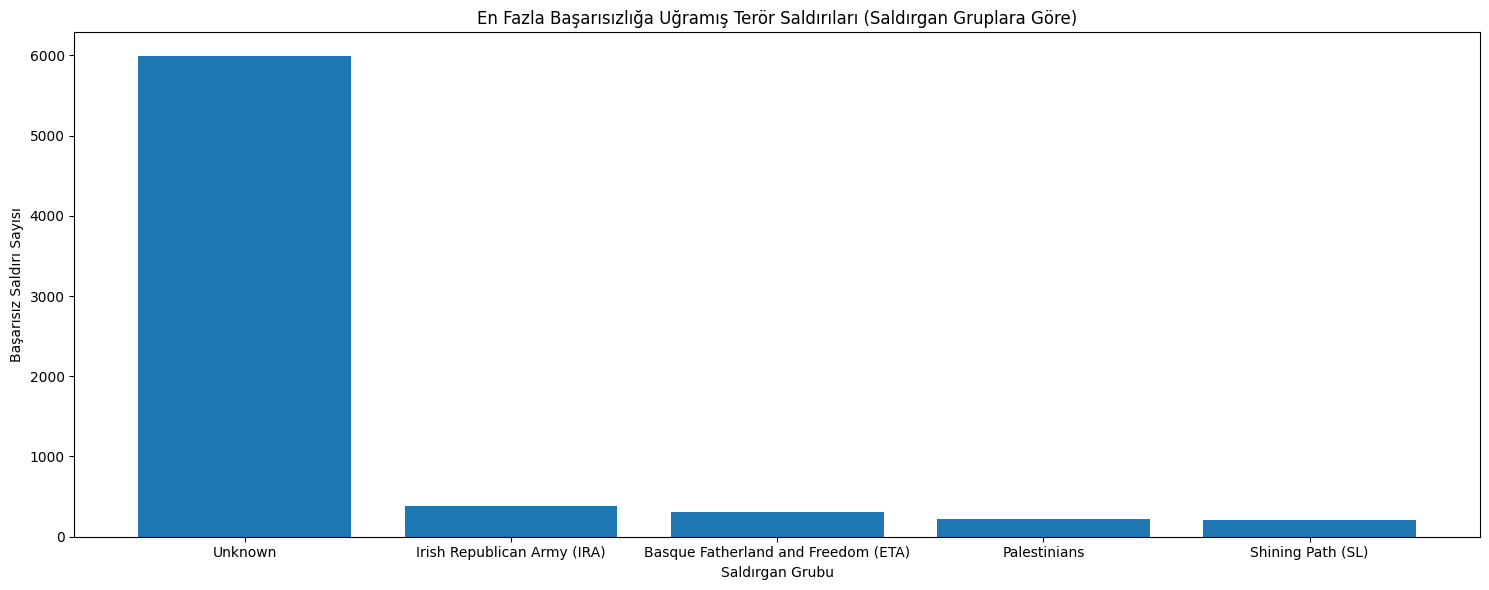

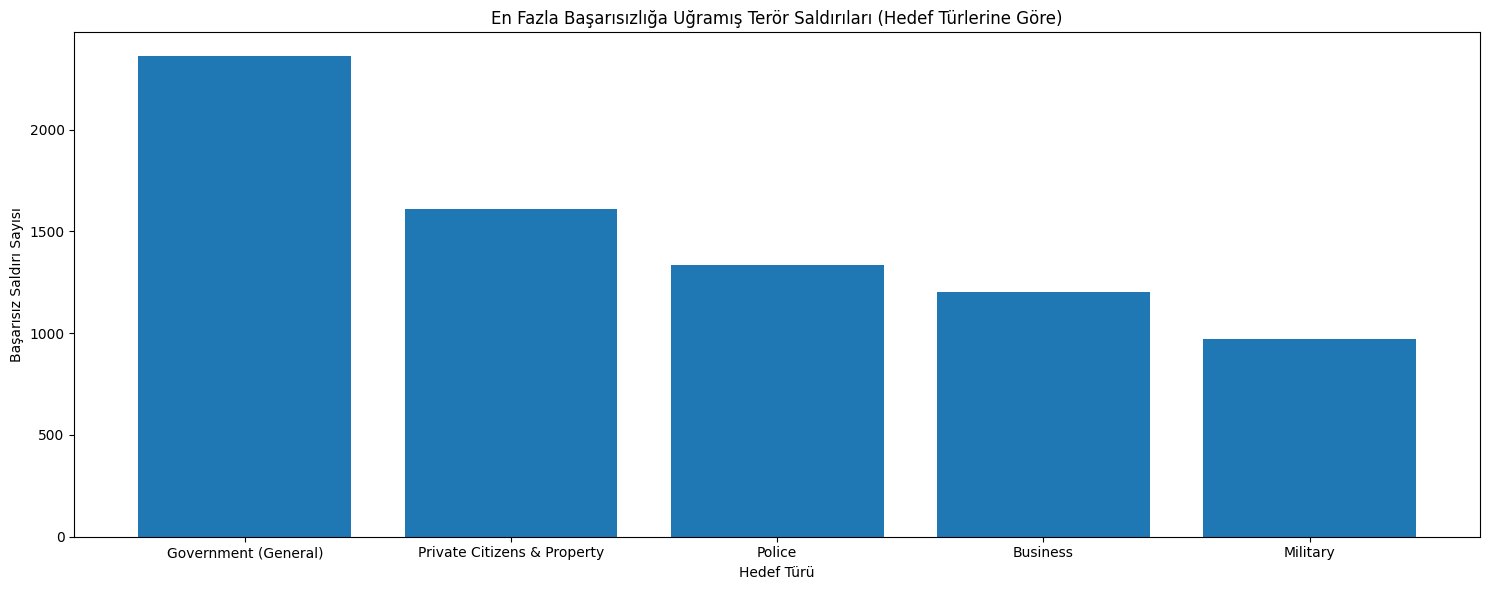

In [229]:
import matplotlib.pyplot as plt


# En fazla başarısızlığa uğramış terör saldırılarını gruplandırma ve sayma
failed_attacks = terrors.filter(terrors["success"] == "0").groupBy("gname").count().sort("count", ascending=False).limit(5)

# Hedeflere göre başarısız saldırıları gruplandırma ve sayma
target_types = terrors.filter(terrors["success"] == "0").groupBy("targtype1_txt").count().sort("count", ascending=False).limit(5)

# Verileri toplam başarısız saldırı sayısına göre grafik olarak çizme
attack_labels = [row.gname for row in failed_attacks.collect()]
attack_counts = [row["count"] for row in failed_attacks.collect()]

plt.figure(figsize=(15, 6))
plt.bar(attack_labels, attack_counts)
plt.xlabel("Saldırgan Grubu")
plt.ylabel("Başarısız Saldırı Sayısı")
plt.title("En Fazla Başarısızlığa Uğramış Terör Saldırıları (Saldırgan Gruplara Göre)")
plt.tight_layout()
plt.show()

# Verileri hedef türüne göre grafik olarak çizme
target_labels = [row.targtype1_txt for row in target_types.collect()]
target_counts = [row["count"] for row in target_types.collect()]

plt.figure(figsize=(15, 6))
plt.bar(target_labels, target_counts)
plt.xlabel("Hedef Türü")
plt.ylabel("Başarısız Saldırı Sayısı")
plt.title("En Fazla Başarısızlığa Uğramış Terör Saldırıları (Hedef Türlerine Göre)")
plt.tight_layout()
plt.show()


Soru - En çok başarıya ulaşmış ilk 5 terör saldırısı hangi hedeflere karşı yapılmıştır?

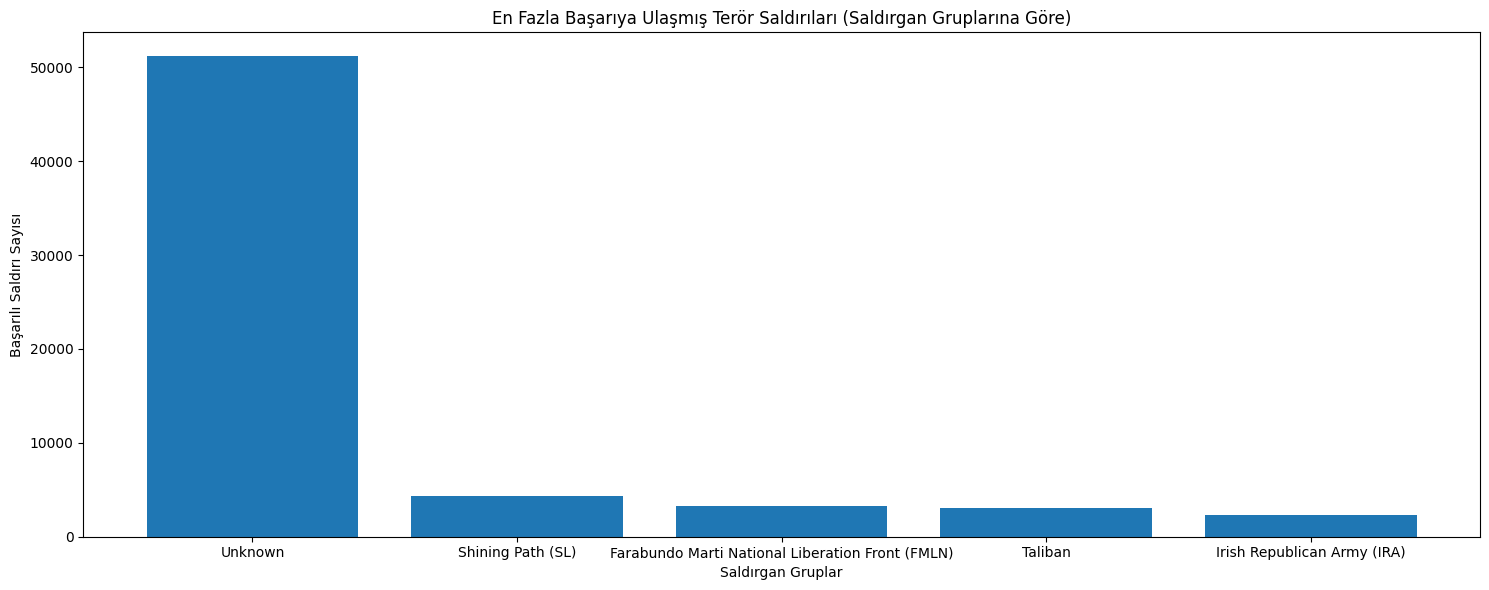

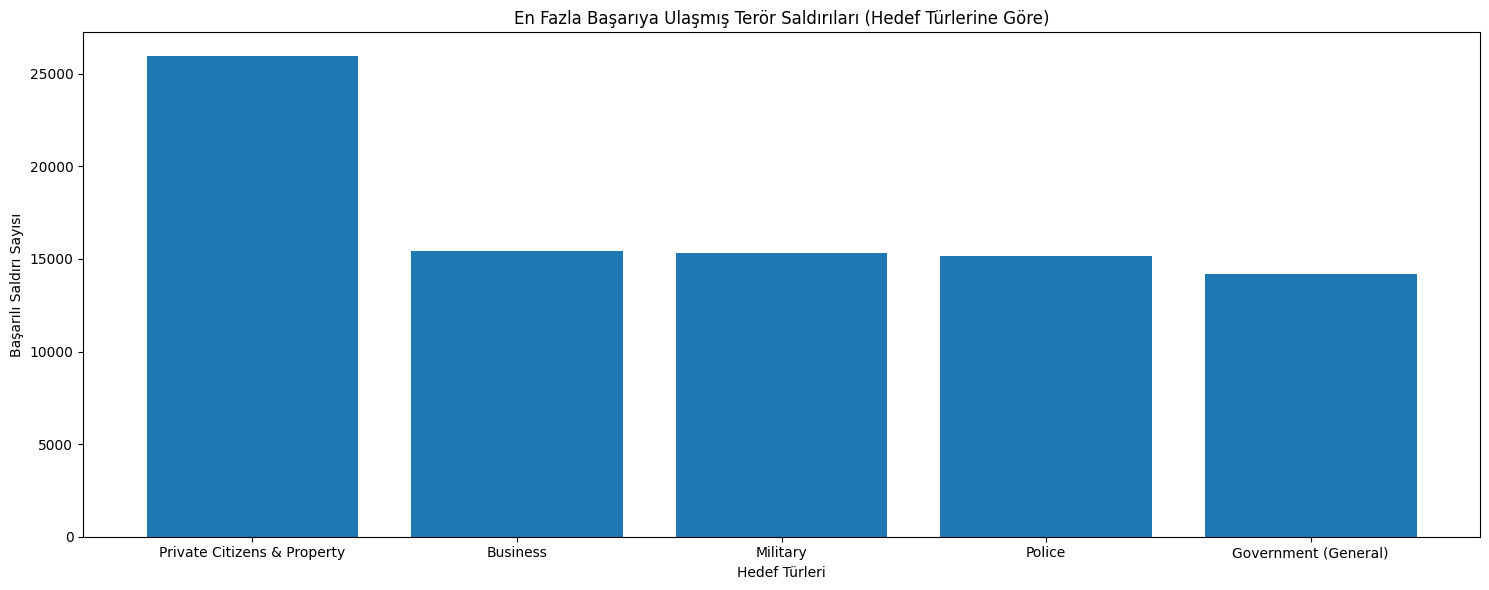

In [237]:
# En çok başarıya ulaşmış ilk 5 terör saldırısını hedeflere göre gruplandırma
successful_attacks = terrors.filter(terrors["success"] == "1").groupBy("targtype1_txt").count().sort("count", ascending=False).limit(5)

# En çok başarıya ulaşmış terör saldırılarını saldırgan gruplara göre gruplandırma
successful_groups = terrors.filter(terrors["success"] == "1").groupBy("gname").count().sort("count", ascending=False).limit(5)

# Saldırgan gruplar için grafik çizme
labels1 = [row.gname for row in successful_groups.collect()]
counts1 = [row["count"] for row in successful_groups.collect()]

plt.figure(figsize=(15, 6))
plt.bar(labels1, counts1)
# plt.xticks(rotation=45)
plt.xlabel("Saldırgan Gruplar")
plt.ylabel("Başarılı Saldırı Sayısı")
plt.title("En Fazla Başarıya Ulaşmış Terör Saldırıları (Saldırgan Gruplarına Göre)")
plt.tight_layout()
plt.show()

# Hedef türleri için grafik çizme
labels2 = [row.targtype1_txt for row in successful_attacks.collect()]
counts2 = [row["count"] for row in successful_attacks.collect()]

plt.figure(figsize=(15, 6))
plt.bar(labels2, counts2)
# plt.xticks(rotation=45)
plt.xlabel("Hedef Türleri")
plt.ylabel("Başarılı Saldırı Sayısı")
plt.title("En Fazla Başarıya Ulaşmış Terör Saldırıları (Hedef Türlerine Göre)")
plt.tight_layout()
plt.show()


Soru - Yapılan saldırılarda hedeflere karşı kullanılan silahların saldırıyı gerçekleştiren terör örgütleriyle (bilinen veya unknow olmayan) dağılımı nasıldır? Dağılımlarının grafiği nedir? Ve bu kullanılan silaha göre saldırıların bir başarı oranı var mıdır? İki grafik şeklinde gösteriniz.

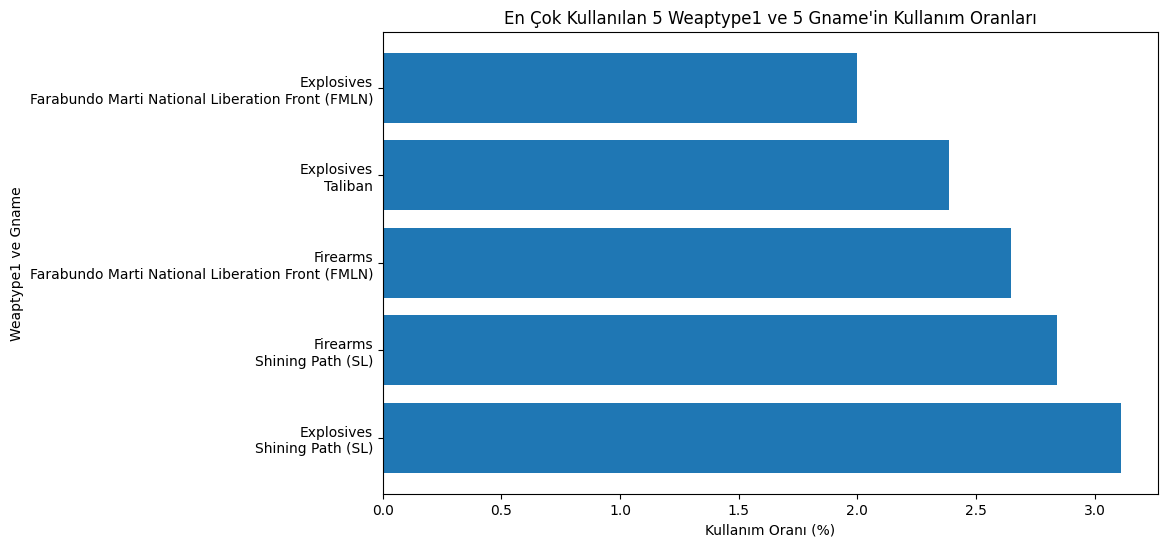

In [15]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Hedeflere karşı kullanılan weaptype1'leri ve saldırıyı gerçekleştiren gname'leri gruplayın ve sayılarını hesaplayın
weapon_gname_counts = terrors.filter(col("gname") != "Unknown") \
    .groupBy("weaptype1_txt", "gname").count().orderBy(col("count").desc())

# En çok kullanılan 5 weaptype1 ve 5 gname'i seçin
top_weapon_gname_counts = weapon_gname_counts.limit(5).collect()

# Kullanım oranlarını hesaplayın
total_counts = terrors.filter(col("gname") != "Unknown").count()
usage_percentages = [(row["weaptype1_txt"], row["gname"], row["count"] / total_counts * 100) for row in top_weapon_gname_counts]

# Grafik için verileri ayrıştırın
weaptype1 = []
gname = []
usage_percentage = []

for row in usage_percentages:
    weaptype1.append(row[0])
    gname.append(row[1])
    usage_percentage.append(row[2])

# Grafik oluşturma
plt.figure(figsize=(10, 6))
plt.barh(range(len(usage_percentage)), usage_percentage, align='center')
plt.xlabel("Kullanım Oranı (%)")
plt.ylabel("Weaptype1 ve Gname")
plt.title("En Çok Kullanılan 5 Weaptype1 ve 5 Gname'in Kullanım Oranları")

# Etiketleri güncelleme
labels = [f"{w}\n{g}" for w, g in zip(weaptype1, gname)]
plt.yticks(range(len(usage_percentage)), labels)

plt.show()


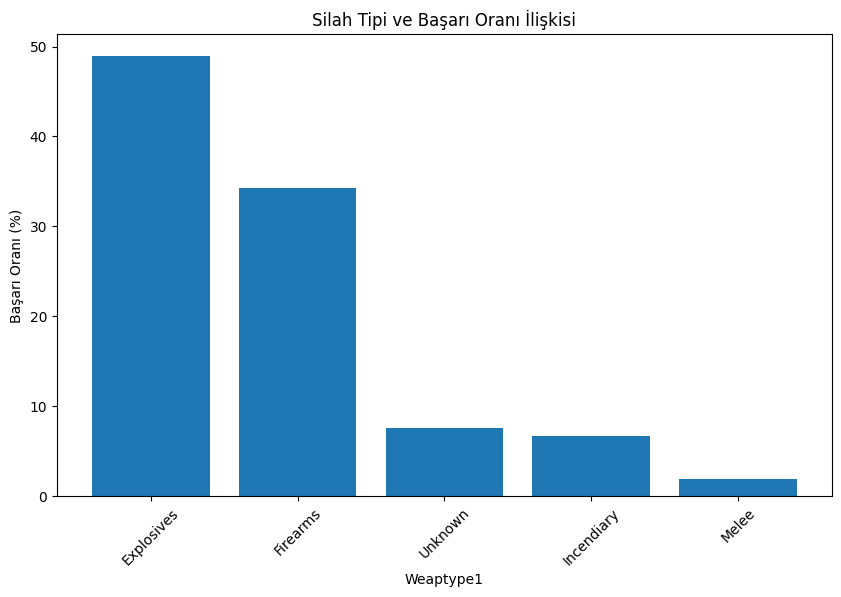

In [23]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Hedeflere karşı kullanılan weaptype1'leri gruplayın ve sayılarını hesaplayın
weapon_counts = terrors.filter(col("weaptype1_txt").isNotNull()) \
    .groupBy("weaptype1_txt").count().orderBy(col("count").desc()).limit(5)

# Silah tiplerini ve başarı oranlarını hesaplayın
total_counts = terrors.filter(col("weaptype1_txt").isNotNull()).count()
success_rates = [(row["weaptype1_txt"], row["count"] / total_counts * 100) for row in weapon_counts.collect()]

# Grafik için verileri ayrıştırın
weaptype1 = []
success_rate = []

for row in success_rates:
    weaptype1.append(row[0])
    success_rate.append(row[1])

# Grafik oluşturma
plt.figure(figsize=(10, 6))
plt.bar(range(len(success_rate)), success_rate)
plt.xlabel("Weaptype1")
plt.ylabel("Başarı Oranı (%)")
plt.title("Silah Tipi ve Başarı Oranı İlişkisi")
plt.xticks(range(len(success_rate)), weaptype1, rotation=45)
plt.show()


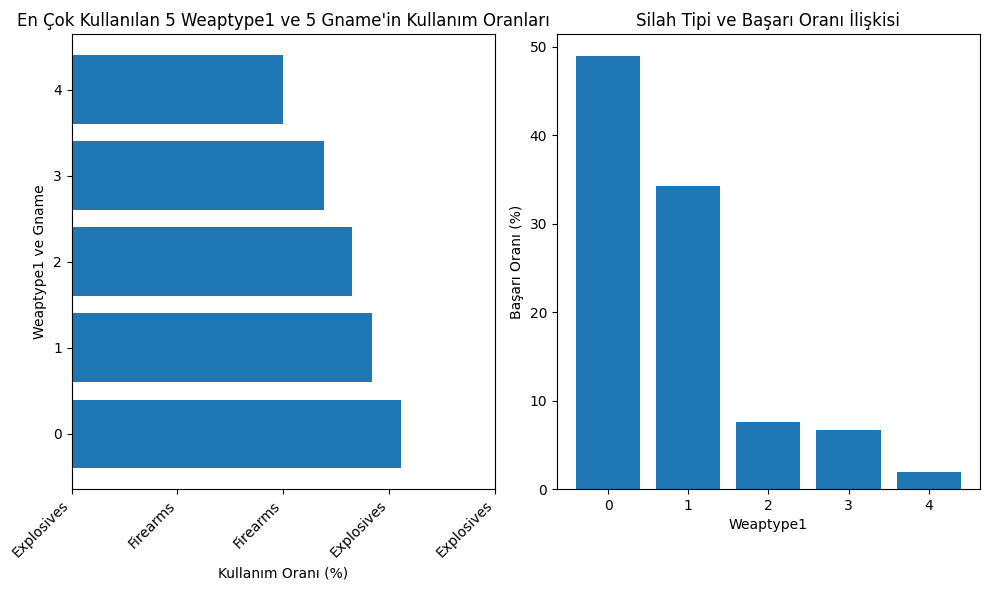

In [9]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Hedeflere karşı kullanılan weaptype1'leri ve saldırıyı gerçekleştiren gname'leri gruplayın ve sayılarını hesaplayın
weapon_gname_counts = terrors.filter(col("gname") != "Unknown") \
    .groupBy("weaptype1_txt", "gname").count().orderBy(col("count").desc())

# En çok kullanılan 5 weaptype1 ve 5 gname'i seçin
top_weapon_gname_counts = weapon_gname_counts.limit(5).collect()

# Kullanım oranlarını hesaplayın
total_counts = terrors.filter(col("gname") != "Unknown").count()
usage_percentages = [(row["weaptype1_txt"], row["gname"], row["count"] / total_counts * 100) for row in top_weapon_gname_counts]

# Grafik için verileri ayrıştırın
weaptype1 = []
gname = []
usage_percentage = []

for row in usage_percentages:
    weaptype1.append(row[0])
    gname.append(row[1])
    usage_percentage.append(row[2])

# İlk grafik: En Çok Kullanılan 5 Weaptype1 ve 5 Gname'in Kullanım Oranları
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.barh(range(len(usage_percentage)), usage_percentage, align='center')
plt.xlabel("Kullanım Oranı (%)")
plt.ylabel("Weaptype1 ve Gname")
plt.title("En Çok Kullanılan 5 Weaptype1 ve 5 Gname'in Kullanım Oranları")

# Etiketleri güncelleme
# labels = [f"{w}\n{g}" for w, g in zip(weaptype1, gname)]
plt.xticks(range(len(success_rate)), weaptype1, rotation=45, ha="right")

# Hedeflere karşı kullanılan weaptype1'leri gruplayın ve sayılarını hesaplayın
weapon_counts = terrors.filter(col("weaptype1_txt").isNotNull()) \
    .groupBy("weaptype1_txt").count().orderBy(col("count").desc()).limit(5)

# Silah tiplerini ve başarı oranlarını hesaplayın
total_counts = terrors.filter(col("weaptype1_txt").isNotNull()).count()
success_rates = [(row["weaptype1_txt"], row["count"] / total_counts * 100) for row in weapon_counts.collect()]

# Grafik için verileri ayrıştırın
weaptype1 = []
success_rate = []

for row in success_rates:
    weaptype1.append(row[0])
    success_rate.append(row[1])

# İkinci grafik: Silah Tipi ve Başarı Oranı İlişkisi
plt.subplot(122)
plt.bar(range(len(success_rate)), success_rate)
plt.xlabel("Weaptype1")
plt.ylabel("Başarı Oranı (%)")
plt.title("Silah Tipi ve Başarı Oranı İlişkisi")



plt.tight_layout()
plt.show()


Soru - En fazla terör olayı hangi gruplar veya örgütler tarafından gerçekleştrilmiştir

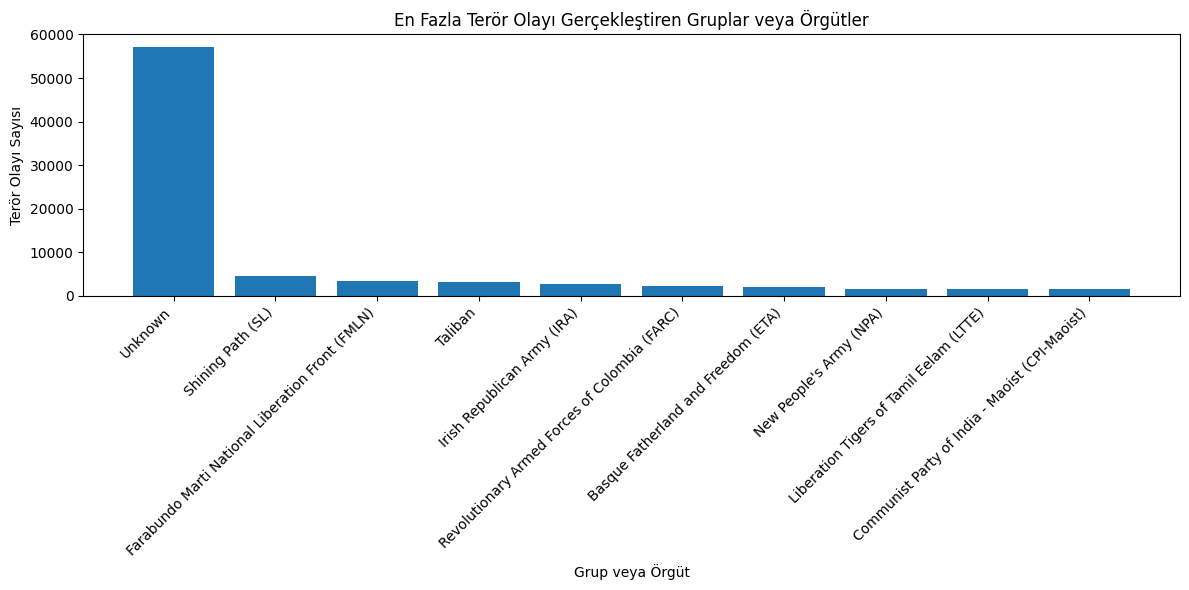

In [10]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Terör olaylarını gerçekleştiren grupları saymak için veriyi gruplayın ve sayıları hesaplayın
group_counts = terrors.groupBy("gname").count().orderBy(col("count").desc()).limit(10)

# Grup adlarını ve sayıları ayrıştırın
group_names = [row["gname"] for row in group_counts.collect()]
event_counts = [row["count"] for row in group_counts.collect()]

# Grafik oluşturma
plt.figure(figsize=(12, 6))
plt.bar(group_names, event_counts)
plt.xlabel("Grup veya Örgüt")
plt.ylabel("Terör Olayı Sayısı")
plt.title("En Fazla Terör Olayı Gerçekleştiren Gruplar veya Örgütler")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()


Soru - En fazla rehineyi hangi terör örgütü almıştır ve en fazla rehine hangi ülkeden alınmıştır

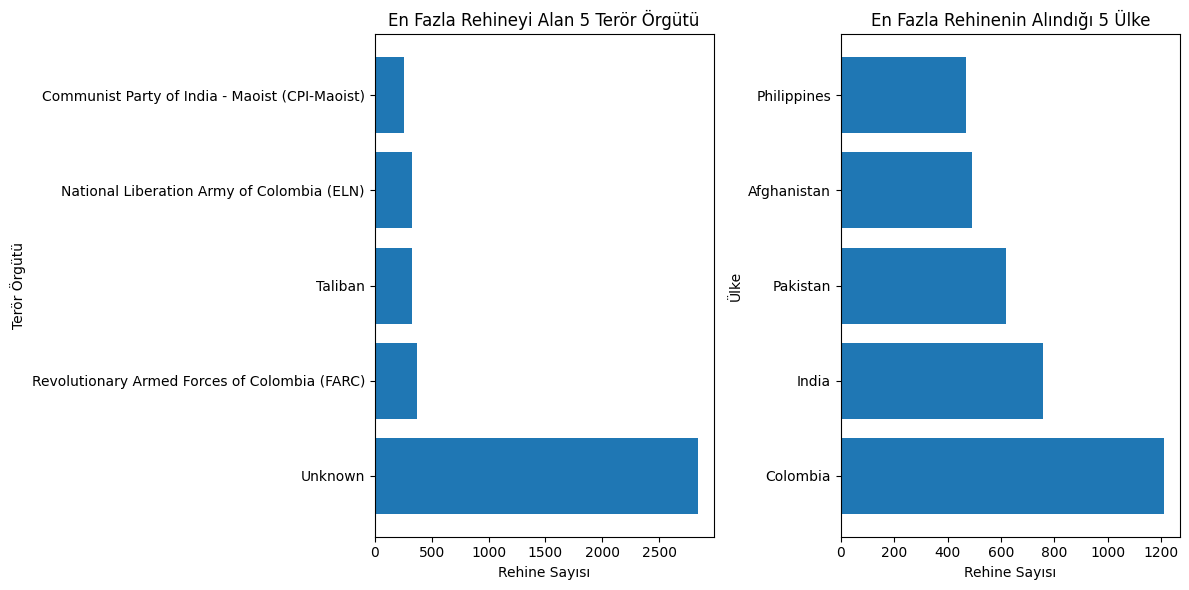

In [15]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# En fazla rehineyi alan 5 terör örgütünü bulmak için veriyi gruplayın ve sayıları hesaplayın
hostage_groups = terrors.filter(col("ishostkid") == 1).groupBy("gname").count().orderBy(col("count").desc()).limit(5)

# Terör örgütü adlarını ve rehine sayılarını ayrıştırın
group_names = [row["gname"] for row in hostage_groups.collect()]
hostage_counts = [row["count"] for row in hostage_groups.collect()]

# Grafik oluşturma: En fazla rehineyi alan 5 terör örgütü
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.barh(group_names, hostage_counts)
plt.xlabel("Rehine Sayısı")
plt.ylabel("Terör Örgütü")
plt.title("En Fazla Rehineyi Alan 5 Terör Örgütü")

# En fazla rehinenin alındığı 5 ülkeyi bulmak için veriyi gruplayın ve sayıları hesaplayın
hostage_countries = terrors.filter(col("ishostkid") == 1).groupBy("country_txt").count().orderBy(col("count").desc()).limit(5)

# Ülke adlarını ve rehine sayılarını ayrıştırın
country_names = [row["country_txt"] for row in hostage_countries.collect()]
hostage_country_counts = [row["count"] for row in hostage_countries.collect()]

# Grafik oluşturma: En fazla rehinenin alındığı 5 ülke
plt.subplot(122)
plt.barh(country_names, hostage_country_counts)
plt.xlabel("Rehine Sayısı")
plt.ylabel("Ülke")
plt.title("En Fazla Rehinenin Alındığı 5 Ülke")

plt.tight_layout()
plt.show()


Soru - en fazla ölüme sebep olan terör örgütü nedir

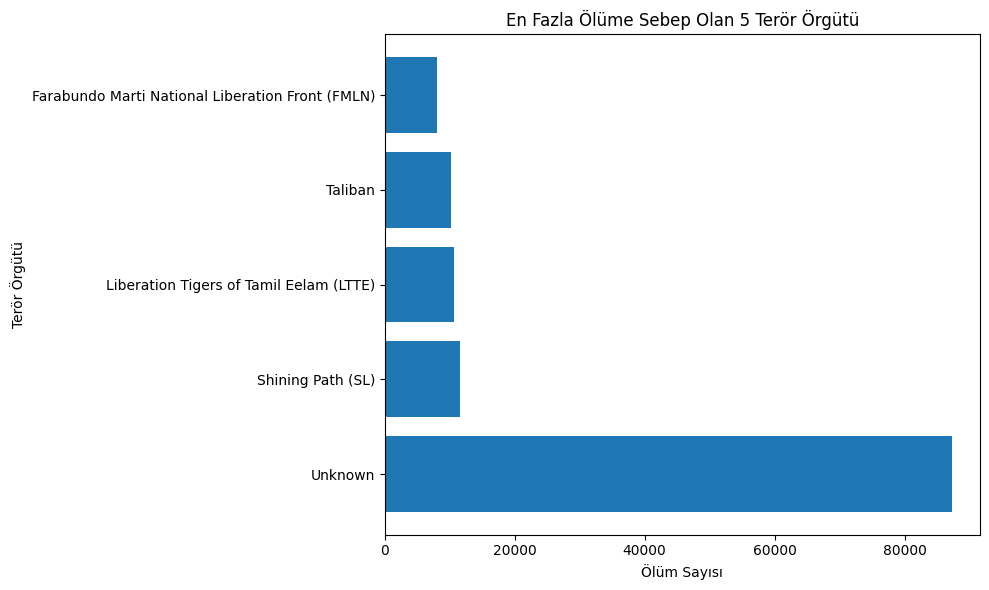

In [23]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# "nkill" sütununu integer'a dönüştürme
terrors = terrors.withColumn("nkill", col("nkill").cast("integer"))

# En fazla ölüme sebep olan terör örgütünü bulmak için veriyi gruplayın ve ölüm sayılarını hesaplayın
terror_groups = terrors.groupBy("gname").sum("nkill").orderBy(col("sum(nkill)").desc()).limit(5)

# Terör örgütü adlarını ve ölüm sayılarını ayrıştırın
group_names = [row["gname"] for row in terror_groups.collect()]
death_counts = [row["sum(nkill)"] for row in terror_groups.collect()]

# Grafik oluşturma: En fazla ölüme sebep olan terör örgütü
plt.figure(figsize=(10, 6))
plt.barh(group_names, death_counts)
plt.xlabel("Ölüm Sayısı")
plt.ylabel("Terör Örgütü")
plt.title("En Fazla Ölüme Sebep Olan 5 Terör Örgütü")

plt.tight_layout()
plt.show()


Soru - dünydaki terör olaylarının yüzde kaçı olayı üstlenmiştir yüzde kaçı bilinmemektedir

Üstlenilen Olayların Yüzdesi: 47.13%
Üstlenilmeyen Olayların Yüzdesi: 52.87%


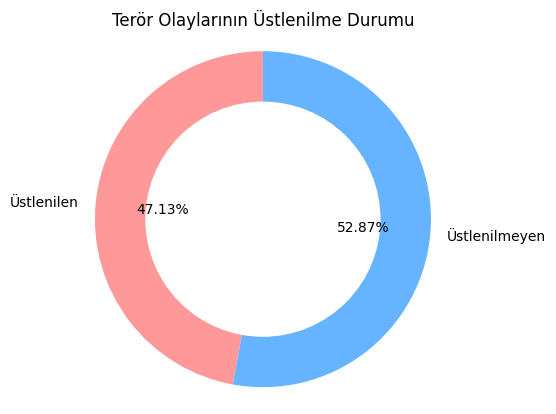

In [29]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Tüm terör olaylarının sayısını hesaplayın
total_incidents = terrors.count()

# Terör olaylarının üstlenildiği olayların sayısını hesaplayın
claimed_incidents = terrors.filter(col("claimed").isNotNull()).count()

# Terör olaylarının üstlenilmediği olayların sayısını hesaplayın
unclaimed_incidents = total_incidents - claimed_incidents

# Yüzdelik oranları hesaplayın
claimed_percentage = (claimed_incidents / total_incidents) * 100
unclaimed_percentage = (unclaimed_incidents / total_incidents) * 100

print("Üstlenilen Olayların Yüzdesi: {:.2f}%".format(claimed_percentage))
print("Üstlenilmeyen Olayların Yüzdesi: {:.2f}%".format(unclaimed_percentage))

# Verileri ve etiketleri tanımla
labels = ['Üstlenilen', 'Üstlenilmeyen']
sizes = [claimed_percentage, unclaimed_percentage]

# Renkleri belirle
colors = ['#ff9999', '#66b3ff']

# Pasta grafiğini oluştur
plt.pie(sizes, labels=labels, colors=colors, autopct='%.2f%%', startangle=90)

# Orta çemberi kapat
centre_circle = plt.Circle((0, 0), 0.70, fc='white') #type: ignore
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Grafiği göster
plt.axis('equal')
plt.title('Terör Olaylarının Üstlenilme Durumu')
plt.show()

Soru - dünyadaki terör olaylarının gerçekleştikleri günlere göre dağılım grafiği nedir

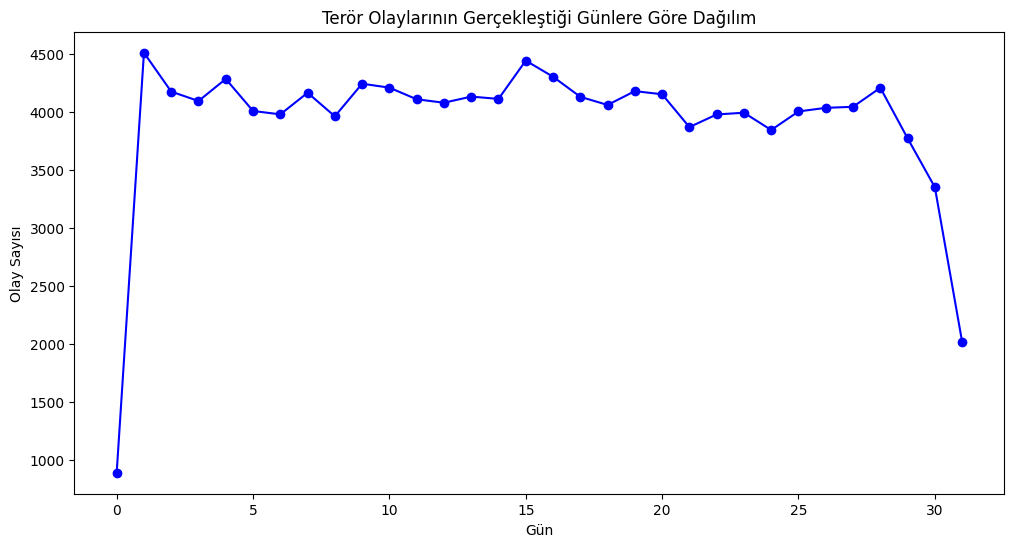

In [35]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Terör olaylarının gerçekleştiği günlere göre sayıları hesaplayın
incident_days = terrors.groupBy("iday").count().orderBy(col("iday")).collect()

# Günlere ve olay sayılarına ayrıştırın
days = [row["iday"] for row in incident_days]
incident_counts = [row["count"] for row in incident_days]

# Grafik oluşturma: Terör olaylarının gerçekleştiği günlere göre dağılım
plt.figure(figsize=(12, 6))
plt.plot(days, incident_counts, marker='o', linestyle='-', color='b')
plt.xlabel("Gün")
plt.ylabel("Olay Sayısı")
plt.title("Terör Olaylarının Gerçekleştiği Günlere Göre Dağılım")

plt.show()


Soru - Terör olayları ağırlıklı olarak hangi mevsimlerde gerçekleşmiştir month değerine göre hesapla

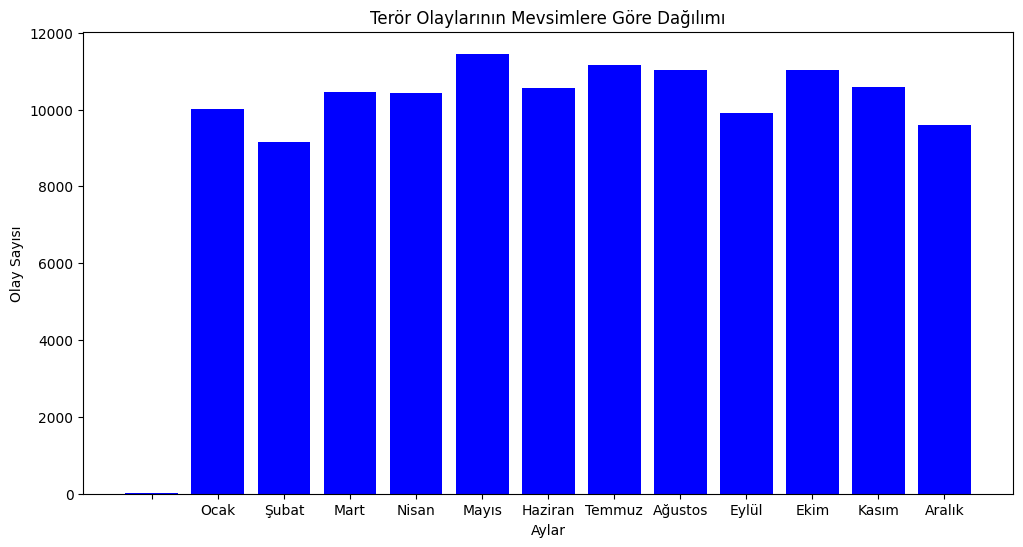

In [51]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# İlgili sütunları seçin ve imonth'a göre gruplayın
incident_seasons = terrors.groupBy("imonth").count().orderBy("imonth").collect()

# Mevsimleri ve olay sayılarını ayrıştırın
seasons = [row["imonth"] for row in incident_seasons]
incident_counts = [row["count"] for row in incident_seasons]

# Mevsim isimlerini ayarlayın
season_names = ["", "Ocak", "Şubat", "Mart", "Nisan", "Mayıs", "Haziran", "Temmuz", "Ağustos", "Eylül", "Ekim", "Kasım", "Aralık"]
# "" değerini ekleme sebebimiz null veya none değerlerinden dolayı hata almak istememiz.

# Grafik oluşturma: Terör olaylarının mevsimlere göre dağılımı
plt.figure(figsize=(12, 6))
plt.bar(seasons, incident_counts, color="blue")
plt.xlabel("Aylar")
plt.ylabel("Olay Sayısı")
plt.title("Terör Olaylarının Mevsimlere Göre Dağılımı")
plt.xticks(seasons, season_names)
plt.show()


Soru - Olaydaki rehine sayısıyla istenilen fidye miktarının büyüklüğü arasında bir ilişki var mıdır?

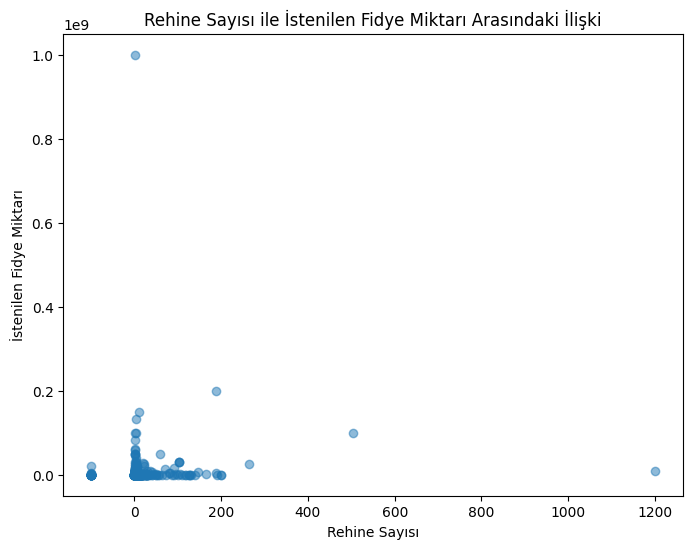

In [59]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Olaydaki rehine sayısı ve istenilen fidye miktarı bilgilerini içeren bir DataFrame oluşturun
hostage_ransom_data = terrors.select("nhostkid", "ransomamt")

# NaN değerleri filtreleyin
hostage_ransom_data = hostage_ransom_data.filter(col("nhostkid").isNotNull() & col("ransomamt").isNotNull())

# Rehine sayısını integer türüne dönüştürün
hostage_ransom_data = hostage_ransom_data.withColumn("nhostkid", col("nhostkid").cast("integer"))

# Fidye miktarını float türüne dönüştürün
hostage_ransom_data = hostage_ransom_data.withColumn("ransomamt", col("ransomamt").cast("float"))

# Verileri ayrıştırın
nhostkid = [row["nhostkid"] for row in hostage_ransom_data.collect()]
ransomamt = [row["ransomamt"] for row in hostage_ransom_data.collect()]

# Grafik oluşturma: Rehine sayısı ve istenilen fidye miktarı arasındaki ilişki
plt.figure(figsize=(8, 6))
plt.scatter(nhostkid, ransomamt, alpha=0.5)
plt.xlabel("Rehine Sayısı")
plt.ylabel("İstenilen Fidye Miktarı")
plt.title("Rehine Sayısı ile İstenilen Fidye Miktarı Arasındaki İlişki")
plt.show()


Soru - En çok fidye talep eden 5 örgüt hangileridir? 

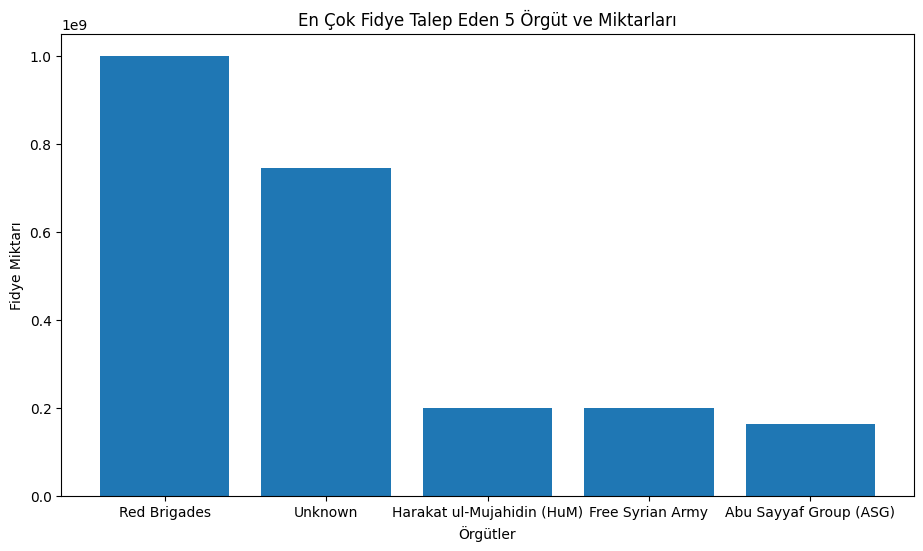

In [74]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Fidye taleplerini ve miktarlarını içeren bir DataFrame oluşturun
ransom_data = terrors.select("gname", "ransomamt")

# NaN değerleri filtreleyin
ransom_data = ransom_data.filter(col("gname").isNotNull() & col("ransomamt").isNotNull())

# Fidye miktarını float türüne dönüştürün
ransom_data = ransom_data.withColumn("ransomamt", col("ransomamt").cast("float"))

# Örgütlerin toplam fidye miktarlEdilen fidye miktarları ne kadardır?arını hesaplayın
grouped_ransom = ransom_data.groupBy("gname").sum("ransomamt").orderBy("sum(ransomamt)", ascending=False)

# En çok fidye talep eden 5 örgütü seçin
top_5_ransom_orgs = grouped_ransom.limit(5).collect()

# Örgüt adlarını ve fidye miktarlarını ayrıştırın
org_names = [row["gname"] for row in top_5_ransom_orgs]
ransom_amounts = [row["sum(ransomamt)"] for row in top_5_ransom_orgs]

# Grafik oluşturma: En çok fidye talep eden 5 örgüt ve miktarları
plt.figure(figsize=(11, 6))
plt.bar(org_names, ransom_amounts)
plt.xlabel("Örgütler")
plt.ylabel("Fidye Miktarı")
plt.title("En Çok Fidye Talep Eden 5 Örgüt ve Miktarları")
plt.show()


Soru - Türkiyeye karşı gerçekleştirilen en fazla terör olayları hangi örgütler tarafından gerçekleştirilmiştir?

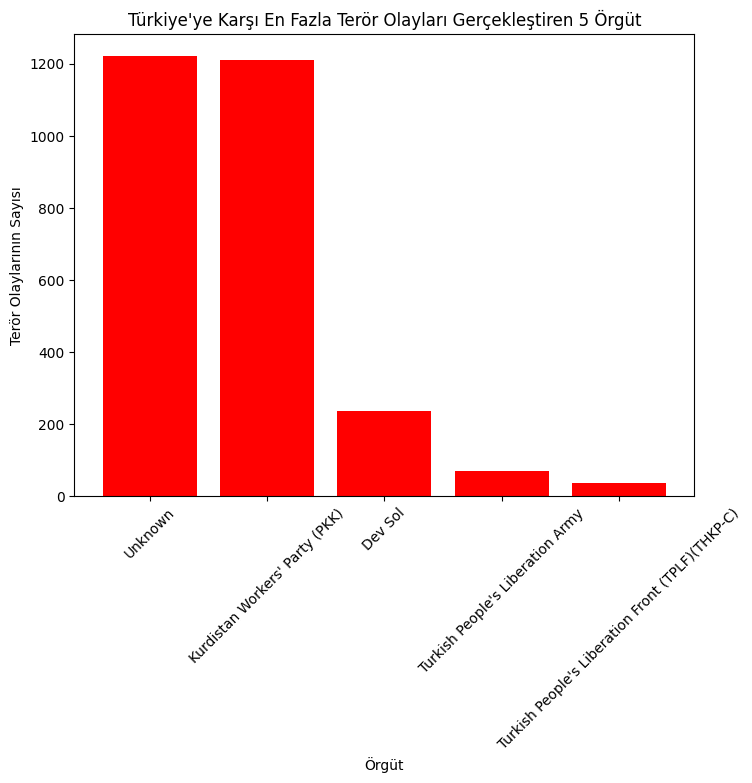

In [77]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Türkiye'ye karşı gerçekleştirilen terör olaylarını içeren bir DataFrame oluşturun
turkey_attacks = terrors.filter(col("country_txt") == "Turkey")

# Örgüt adlarını gruplayın ve terör olaylarının sayısını hesaplayın
attacks_by_group = turkey_attacks.groupBy("gname").count().na.drop().orderBy(col("count").desc()).limit(5).collect()

# Verileri ayrıştırın
groups = [row["gname"] for row in attacks_by_group]
attack_counts = [row["count"] for row in attacks_by_group]

# Grafik oluşturma: Türkiye'ye karşı en fazla terör olayları gerçekleştiren 5 örgüt
plt.figure(figsize=(8, 6))
plt.bar(groups, attack_counts, color="red")
plt.xlabel("Örgüt")
plt.ylabel("Terör Olaylarının Sayısı")
plt.title("Türkiye'ye Karşı En Fazla Terör Olayları Gerçekleştiren 5 Örgüt")
plt.xticks(rotation=45)

plt.show()


Soru - Yaşanan terör olaylarında en falza rehin alma veya kaçırılma hangi ülkelerde olmuştur? 

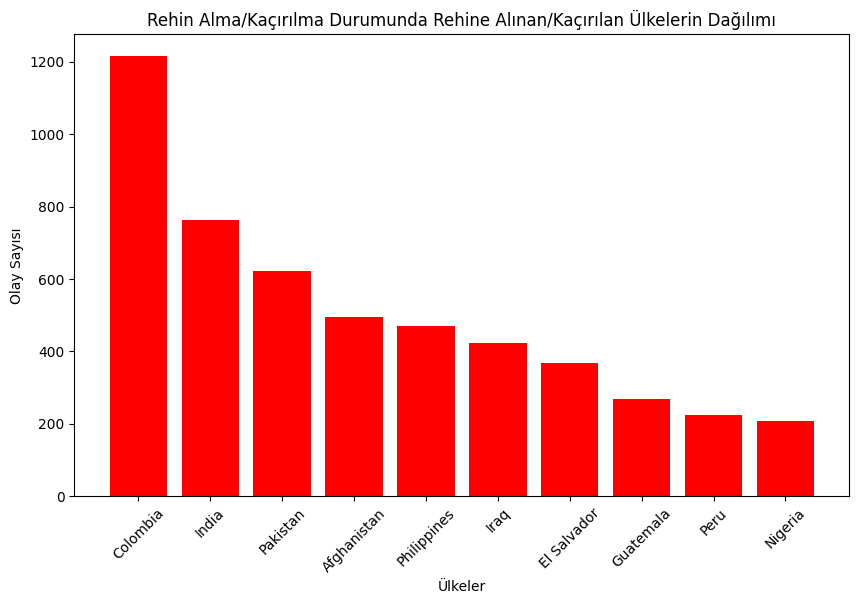

In [80]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Rehin alma veya kaçırılma durumunda rehine alındığı veya kaçırıldığı ülkelerin dağılımını hesaplayın
hostage_countries = terrors.filter((col("ishostkid") == 1) | (col("nhostkid") > 0)) \
                          .groupBy("country_txt") \
                          .count() \
                          .orderBy("count", ascending=False) \
                          .limit(10) \
                          .collect()

# Ülke isimlerini ve olay sayılarını ayrıştırın
countries = [row["country_txt"] for row in hostage_countries]
incident_counts = [row["count"] for row in hostage_countries]

# Grafik oluşturma: Rehin alma veya kaçırılma durumunda rehine alındığı veya kaçırıldığı ülkelerin dağılımı
plt.figure(figsize=(10, 6))
plt.bar(countries, incident_counts, color="red")
plt.xlabel("Ülkeler")
plt.ylabel("Olay Sayısı")
plt.title("Rehin Alma/Kaçırılma Durumunda Rehine Alınan/Kaçırılan Ülkelerin Dağılımı")
plt.xticks(rotation=45)
plt.show()


Soru - Terör örgütlerinin son saldırıları dünyanın nerelerinde gerçekleşmiştir? Terör örgütleri en son nerelerde görülmüştür haritadan işaretleyiniz.

In [115]:
import pydeck as pdk
import pandas as pd

# Terör örgütlerinin en son saldırılarını filtrele ve gerekli sütunları seç
latest_attacks = terrors.groupBy('gname').agg({'iyear': 'max', 'imonth': 'max', 'iday': 'max', 'latitude': 'max', 'longitude': 'max', 'nkill': 'sum', 'nwound': 'sum', 'targtype1': 'max', 'weaptype1': 'max'})
latest_attacks = latest_attacks.withColumnRenamed('max(iyear)', 'year').withColumnRenamed('max(imonth)', 'month').withColumnRenamed('max(iday)', 'day')

# Toplam ölü sayısına göre sıralama yap
latest_attacks = latest_attacks.withColumn('total_casualties', col('sum(nkill)') + col('sum(nwound)'))
window_spec = Window.orderBy(col('total_casualties').desc())
latest_attacks = latest_attacks.withColumn('rank', row_number().over(window_spec))

# UDF (User Defined Function) tanımla
def get_location(latitude, longitude):
    return {'latitude': latitude, 'longitude': longitude}

udf_get_location = udf(get_location, returnType=StructType([
    StructField('latitude', DoubleType()),
    StructField('longitude', DoubleType())
]))

# UDF'yi kullanarak yeni bir sütun oluştur
latest_attacks = latest_attacks.withColumn('location', udf_get_location(col('max(latitude)'), col('max(longitude)')))

# Veriyi pandas DataFrame'e dönüştür
latest_attacks_pd = latest_attacks.select('gname', 'location.latitude', 'location.longitude', 'year', 'max(targtype1)', 'max(weaptype1)').toPandas()

# 3 boyutlu verileri tutacak bir DataFrame oluştur
terrorist_locations_3d = pd.DataFrame(columns=['gname', 'latitude', 'longitude', 'year'])

# Veriyi 3 boyutlu DataFrame'e aktar
for row in latest_attacks_pd.itertuples():
    gname = row.gname
    latitude = row.latitude
    longitude = row.longitude
    year = row.year
    targtype1 = row[5]  # max(targtype1)
    weaptype1 = row[6]  # max(weaptype1)
    terrorist_locations_3d = terrorist_locations_3d.append({'gname': gname, 'latitude': latitude, 'longitude': longitude, 'year': year, 'targtype1': targtype1, 'weaptype1': weaptype1}, ignore_index=True)

# 3 boyutlu harita üzerinde görselleştirme yap
layer = pdk.Layer(
    "ScatterplotLayer",
    data=terrorist_locations_3d,
    get_position=["longitude", "latitude"],
    get_color=[255, 0, 0],
    get_radius=2000,
    radius_min_pixels=10,
    radius_max_pixels=30,
    get_fill_color=[255, 0, 0, 255],
    filled=True,
    pickable=True,
    tooltip=["gname", "latitude", "longitude", "year", "targtype1", "weaptype1"]
)

view_state = pdk.ViewState(
    latitude=terrorist_locations_3d['latitude'].mean(),
    longitude=terrorist_locations_3d['longitude'].mean(),
    zoom=1,
    pitch=45,
    bearing=0
)

r = pdk.Deck(layers=[layer], initial_view_state=view_state)

# 3 boyutlu haritayı görüntüle
r.to_html("3d_map2.html")


/tmp/ipykernel_1621/2791221493.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  terrorist_locations_3d = terrorist_locations_3d.append({'gname': gname, 'latitude': latitude, 'longitude': longitude, 'year': year, 'targtype1': targtype1, 'weaptype1': weaptype1}, ignore_index=True)
/tmp/ipykernel_1621/2791221493.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  terrorist_locations_3d = terrorist_locations_3d.append({'gname': gname, 'latitude': latitude, 'longitude': longitude, 'year': year, 'targtype1': targtype1, 'weaptype1': weaptype1}, ignore_index=True)
/tmp/ipykernel_1621/2791221493.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  terrorist_locations_3d = terrorist_locations_3d.append({'gname': gname, 'latitude